In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import string
from pickle import load, dump
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_direction = "/content/drive/My Drive/DataSets"
all_image_names = os.listdir(os.path.join(root_direction,'Flicker/Flickr8k_Dataset/Flicker8k_Dataset'))

### Number of Samples

In [ ]:
len(all_image_names)

8091

### Read the Data

In [ ]:
def load_image(name):
    img = image.load_img(name,target_size=(32,32,3))
    img = image.img_to_array(img)
    #img = img/255
    #plt.imshow(img)
    img = np.reshape(img,(32*32*3))
    return img

In [ ]:
def load_doc(filename):

	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text
 
filename = '/content/drive/MyDrive/DataSets/Flicker/Flickr8k_text/Flickr8k.token.txt'
doc = load_doc(filename)

In [ ]:
def load_descriptions(doc):

	mapping = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		if len(line) < 2:
			continue
		image_id, image_desc = tokens[0], tokens[1:]
		image_id = image_id.split('.')[0]
		image_desc = ' '.join(image_desc)
		if image_id not in mapping:
			mapping[image_id] = list()
		mapping[image_id].append(image_desc)
	return mapping

descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [ ]:
descriptions['2083434441_a93bc6306b']

['an elderly woman is riding a bicycle in the city as a yellow taxi is about to pass by .',
 'An elderly woman rides a bicycle along a city street .',
 'An older woman with blond hair rides a bicycle down the street .',
 'A woman in a grey overcoat rides her bicycle along a street .',
 'Older woman wearing glassses riding a bicycle with a shopping bag on the handle , yellow car is in the background .']

In [ ]:
def clean_descriptions(descriptions):

	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			desc = desc.split()
			desc = [word.lower() for word in desc]
			desc = [w.translate(table) for w in desc]
			desc = [word for word in desc if len(word)>1]
			desc = [word for word in desc if word.isalpha()]
			desc_list[i] =  ' '.join(desc)

clean_descriptions(descriptions)

In [ ]:
type(descriptions)

dict

In [ ]:
len(list(descriptions.items()))

8092

In [ ]:
descriptions.keys()

dict_keys(['1000268201_693b08cb0e', '1001773457_577c3a7d70', '1002674143_1b742ab4b8', '1003163366_44323f5815', '1007129816_e794419615', '1007320043_627395c3d8', '1009434119_febe49276a', '1012212859_01547e3f17', '1015118661_980735411b', '1015584366_dfcec3c85a', '101654506_8eb26cfb60', '101669240_b2d3e7f17b', '1016887272_03199f49c4', '1019077836_6fc9b15408', '1019604187_d087bf9a5f', '1020651753_06077ec457', '1022454332_6af2c1449a', '1022454428_b6b660a67b', '1022975728_75515238d8', '102351840_323e3de834', '1024138940_f1fefbdce1', '102455176_5f8ead62d5', '1026685415_0431cbf574', '1028205764_7e8df9a2ea', '1030985833_b0902ea560', '103106960_e8a41d64f8', '103195344_5d2dc613a3', '103205630_682ca7285b', '1032122270_ea6f0beedb', '1032460886_4a598ed535', '1034276567_49bb87c51c', '104136873_5b5d41be75', '1042020065_fb3d3ba5ba', '1042590306_95dea0916c', '1045521051_108ebc19be', '1048710776_bb5b0a5c7c', '1052358063_eae6744153', '105342180_4d4a40b47f', '1053804096_ad278b25f1', '1055623002_8195a43714'

In [ ]:
for i , key in enumerate(all_image_names):
  if i < 10:
    print(descriptions[key[:-4]])

['dog is jumping over log in wooded area while carrying another log', 'dog with stick in his mouth jumps over fallen tree in the forest', 'dog carries stick and jumps over log', 'the dog carries stick and jumps over log in the woods', 'the dog jumps over the log with stick in its mouth']
['black and brown dog is running between two cement barriers with snow', 'dog runs down the cold aisle', 'black and tan small dog walking with perked ears', 'the black and brown dog walks toward the camera in an enclosed snowy area', 'the brown and black dog is running through snowy street']
['furry dog is running through doorway leading to plants', 'furry tan dog is outside on patio', 'short furry dog stands on brick floor in front of group of potted plants', 'very hairy dog is running down hall', 'flowers are behind the fluffy dog that is coming up the step']
['brown and black dog runs through the leaves', 'brown dog is running', 'brown dog with red collar jumping across leafy lawn', 'dog with brindl

In [ ]:
def load_dataset_names(dataset_type):
  text_location = os.path.join(root_direction,'Flicker/Flickr8k_text/Flickr_8k.{}Images.txt'.format(dataset_type))
  with open(text_location, 'r') as f:
    names = f.readlines()
  names = [x.strip('\n') for x in names] 
  return names

In [ ]:
train_names, dev_names, test_names = load_dataset_names('train'), load_dataset_names('dev'), load_dataset_names('test')

In [ ]:
print(len(train_names), " !!! ", len(dev_names), " @@@@ ", len(test_names))

6000  !!!  1000  @@@@  1000


In [ ]:
train_image_arr = []
train_sentence_arr = []
for name in tqdm(train_names):
  image_location = name
  sentence = descriptions[name[:-4]][0]

  #train_image_arr.append(load_image(os.path.join(root_direction,'Flicker/Flickr8k_Dataset/Flicker8k_Dataset', image_location)))
  train_sentence_arr.append('<SOS> '+sentence+' <EOS>')
    
        
#Train_Images =  np.array(train_image_arr)

100%|██████████| 6000/6000 [00:00<00:00, 457543.80it/s]


In [ ]:
if os.path.exists('/content/drive/MyDrive/DataSets/Flicker/TIC_Folder/Reshaped_images.pickle'):
  with open('/content/drive/MyDrive/DataSets/Flicker/TIC_Folder/Reshaped_images.pickle', 'rb') as f:
    Train_Images = load(f)
else:
  with open('/content/drive/MyDrive/DataSets/Flicker/TIC_Folder/Reshaped_images.pickle', 'wb') as f:
    dump(Train_Images, f)

In [ ]:
Train_Images.shape

(6000, 3072)

In [ ]:
def tokenize(x):
    tokenizer=Tokenizer()
    tokenizer.fit_on_texts(x)
    t=tokenizer.texts_to_sequences(x)
    return t, tokenizer

In [ ]:
def pad(x, length=None):
    padding=pad_sequences(x,padding='post',maxlen=length)
    return padding

In [ ]:
def preprocess(sentences):
    text_tokenized, text_tokenizer = tokenize(sentences)
    text_pad = pad(text_tokenized)
    return text_pad, text_tokenizer

Train_Sentence , token_Sentence = preprocess(train_sentence_arr)

In [ ]:
print("Sentence vocabulary size:", len(token_Sentence.word_index))
print("Sentence Longest sentence size:", len(Train_Sentence[0]))

Sentence vocabulary size: 3847
Sentence Longest sentence size: 30


In [ ]:
Train_Images.shape , Train_Sentence.shape

((6000, 3072), (6000, 30))

In [ ]:
Train_Sentence

array([[   1,   12,    8, ...,    0,    0,    0],
       [   1,   51,  100, ...,    0,    0,    0],
       [   1,   16,    8, ...,    0,    0,    0],
       ...,
       [   1,  264, 1319, ...,    0,    0,    0],
       [   1, 3846,    5, ...,    0,    0,    0],
       [   1,   51,   15, ...,    0,    0,    0]], dtype=int32)

In [ ]:
def create_batch(src, tar , batchsize , i):
    src, tar =  np.transpose(src[(i-1)*batchsize : (i-1)*batchsize + batchsize]) , np.transpose(tar[(i-1)*batchsize : (i-1)*batchsize + batchsize])
    return torch.tensor(src).long(),torch.tensor(tar).long()

# Modeling Transformer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
class Transformer(nn.Module):
    def __init__(
        self,
        embedding_size,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        forward_expansion,
        dropout,
        max_len_s,
        max_len_t,
        device,
    ):
        super(Transformer, self).__init__()
        self.src_word_embedding = nn.Embedding(src_vocab_size, embedding_size)
        self.src_position_embedding = nn.Embedding(max_len_s, embedding_size)
        self.trg_word_embedding = nn.Embedding(trg_vocab_size, embedding_size)
        self.trg_position_embedding = nn.Embedding(max_len_t, embedding_size)

        self.device = device
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
        )
        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.src_pad_idx = src_pad_idx

    def make_src_mask(self, src):
        src_mask = src.transpose(0, 1) == self.src_pad_idx

        # (N, src_len)
        return src_mask.to(self.device)

    def forward(self, src, trg):
        src_seq_length, N = src.shape
        trg_seq_length, N = trg.shape

        src_positions = (
            torch.arange(0, src_seq_length)
            .unsqueeze(1)
            .expand(src_seq_length, N)
            .to(self.device)
        )

        trg_positions = (
            torch.arange(0, trg_seq_length)
            .unsqueeze(1)
            .expand(trg_seq_length, N)
            .to(self.device)
        )

        embed_src = self.dropout(
            (self.src_word_embedding(src) + self.src_position_embedding(src_positions))
        )
        embed_trg = self.dropout(
            (self.trg_word_embedding(trg) + self.trg_position_embedding(trg_positions))
        )

        src_padding_mask = self.make_src_mask(src)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(self.device)
        out = self.transformer(
            embed_src,
            embed_trg,
            src_key_padding_mask=src_padding_mask,
            tgt_mask=trg_mask,
        )
        out = self.fc_out(out)
        return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
def random_samples(images, sentences, count=1000):
  all_samples = []
  for pair in zip(images, sentences):
    all_samples.append(pair)
  random.shuffle(all_samples)
  chosen_samples=random.sample(all_samples, k = count)
  chosen_images, chosen_sentences = np.array([sample[0] for sample in chosen_samples]), np.array([sample[1] for sample in chosen_samples])
  return chosen_images, chosen_sentences  

In [ ]:
Train_Count = 1000

In [ ]:
Sampled_Train_Images, Sampled_Train_Sentences = random_samples(Train_Images, Train_Sentence, Train_Count)

In [ ]:
# Model hyperparameters
src_vocab_size = 256
trg_vocab_size = len(token_Sentence.word_index)
embedding_size = 512
num_heads = 8
num_encoder_layers = 3
num_decoder_layers = 3
dropout = 0.10
max_len_s = 3072 # Sampled_Train_Images.shape[1]
max_len_t = 30 # Sampled_Train_Sentences.shape[1]
forward_expansion = 4
src_pad_idx = 0
Train_Count = 4000
# Training hyperparameters
num_epochs = 10000
learning_rate = 3e-4
batch_size = 3

In [ ]:
# Training hyperparameters
num_epochs = 10000
learning_rate = 3e-4
batch_size = 3

In [ ]:
model = Transformer(
    embedding_size,
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len_s,
    max_len_t,
    device,
).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=10, verbose=True
)

pad_idx = 0
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).cuda()


In [ ]:
stop

In [ ]:
import time
def train():
    model.train() # Turn on the train mode
    total_loss = 0
    start_time = time.time()
    for i in range(len(Sampled_Train_Images)):
        src,tar = create_batch(Sampled_Train_Images,Sampled_Train_Sentences, batch_size , i)
        src = src.to(device)
        tar = tar.to(device)
        optimizer.zero_grad()
        output = model(src,tar)
        loss = criterion(output.view(-1, output.shape[2]), tar.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        cur_loss = loss.item()
        total_loss += cur_loss
        log_interval = 250
        if i % log_interval == 0 and i > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  's/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, i, (src.shape[1]) // batch_size, 
                    elapsed  / log_interval,
                    cur_loss, math.exp(cur_loss)))
            start_time = time.time()
    return total_loss

In [ ]:
import math
for epoch in range(1, 11):
    epoch_start_time = time.time()
    loss = train()
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | Training loss {:5.2f} | '
          .format(epoch, (time.time() - epoch_start_time),
                                     loss))

In [ ]:
with open('/content/drive/MyDrive/Models/Captioner/Transformer/{}'.format('TrModel2.pkl'),'wb') as f:
  dump(model, f)

In [ ]:
def display_image(name):
    img = image.load_img(name,target_size=(512,512,3))
    img = image.img_to_array(img)
    img = img/255
    plt.imshow(img)

In [ ]:
len(dev_names)

1000

In [ ]:
type(dev_names)

list

In [ ]:
print(dev_names)

['2090545563_a4e66ec76b.jpg', '3393035454_2d2370ffd4.jpg', '3695064885_a6922f06b2.jpg', '1679557684_50a206e4a9.jpg', '3582685410_05315a15b8.jpg', '1579798212_d30844b4c5.jpg', '269650644_059a84ece5.jpg', '2596619849_7b635dd310.jpg', '2635164923_2a774f7854.jpg', '3583321426_f373c52161.jpg', '2735792721_b8fe85e803.jpg', '3484841598_e26ee96aab.jpg', '2490687446_9d46fdf5a9.jpg', '2987328689_96a2d814f1.jpg', '2992614450_b5a6692239.jpg', '2391812384_7429b5e567.jpg', '3665179773_dd217416fc.jpg', '3515904775_f8acc5909e.jpg', '3616808182_fb4eaec778.jpg', '3652150541_8fb5a3a5d1.jpg', '3693961165_9d6c333d5b.jpg', '2895700779_fac1d9d278.jpg', '2474092890_6c0781a8ed.jpg', '3420469425_2980b4cd30.jpg', '537222436_ab406234ce.jpg', '3419634480_c390f62a6e.jpg', '2659183350_730951f740.jpg', '1178705300_c224d9a4f1.jpg', '989851184_9ef368e520.jpg', '535123126_c06c1ab9bf.jpg', '3226541300_6c81711e8e.jpg', '3457784061_8f77f43a9c.jpg', '3364715316_df8c20bac1.jpg', '233361142_d9d5f0cae9.jpg', '634891010_9fa189e

In [ ]:
def load_model(address):
  model = None
  with open(address,'rb') as f:
    model = pickle.load(f)
  return model

In [ ]:
transformer_model = load_model('/content/drive/MyDrive/Models/Captioner/Transformer/{}'.format('TrModel.pkl'))

In [ ]:
def Generate_Caption(model,images, sentences, view = True):
  generated_sentences = []
  for image_name in images:
    image_arr = []
    img = load_image('/content/drive/MyDrive/DataSets/Flicker/Flickr8k_Dataset/Flicker8k_Dataset/'+str(image_name))
    image_arr.append(img)
    img_arr = np.array(image_arr)
    sentence = []
    sentence.append(descriptions[image_name[:-4]][1])
    sentence[0] = '<SOS> '+sentence[0]+'<EOS>'
    sentence = pad(token_Sentence.texts_to_sequences(sentence) , length = max_len_t)
    src , tar = create_batch(img_arr,sentence, 1,1)
    src = src.to(device)
    tar = tar.to(device)
    model.eval()
    output =  model(src,tar)
    loss = criterion(output.view(-1, output.shape[2]), tar.reshape(-1))
    sentence_formed = ''
    val, ind = torch.max(output.view(-1, output.shape[2]), 1)
    for word in ind:
      #print('--->'+sentence_formed+'    '+str(word.item()))
      if word.item() == 3: # EOS
        break
      for key, value in token_Sentence.word_index.items():
        #print(value == word.item())
        if value == word.item() and value != 2: # sos
          sentence_formed = sentence_formed + key +' '
          break
    generated_sentences.append(sentence_formed.split(" ")[1:])
    if view:
      x=plt.imread('/content/drive/MyDrive/DataSets/Flicker/Flickr8k_Dataset/Flicker8k_Dataset/'+str(image_name))
      plt.imshow(x)
      plt.show()
      print("Generated_Sentence:")
      print(" ".join(sentence_formed.split(" ")[1:]))
      print("Actual Caption: ")
      print(descriptions[image_name[:-4]][0])
      print()
      print("===========================================")
      print()

  return generated_sentences

In [ ]:
len(descriptions)

8092

In [ ]:
test_examples = ['2435685480_a79d42e564.jpg',
                 '2854959952_3991a385ab.jpg',
                 '2208310655_a3d83080c5.jpg',
                 '3332467180_d72f9b067d.jpg',
                 '3630332976_fdba22c50b.jpg',
                 '3301811927_a2797339e5.jpg',
                 '493109089_468e105233.jpg',
                 ]

In [ ]:
dev_names[30:40]

['3226541300_6c81711e8e.jpg',
 '3457784061_8f77f43a9c.jpg',
 '3364715316_df8c20bac1.jpg',
 '233361142_d9d5f0cae9.jpg',
 '634891010_9fa189effb.jpg',
 '2977379863_2e8d7a104e.jpg',
 '3663951804_868982f3f9.jpg',
 '3170802797_3c851bb475.jpg',
 '2409597310_958f5d8aff.jpg',
 '2384550175_e421d3a871.jpg']

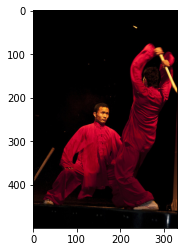

Generated_Sentence:
two men 
Actual Caption: 
two men in magenta costumes performing




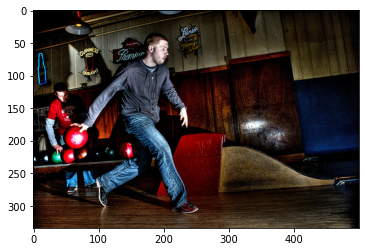

Generated_Sentence:
man gymnastic with red shopping ball picture picture picture female picture picture picture picture off stroller female picture skirt passage get picture picture picture skirt picture skirt picture 
Actual Caption: 
man bowls with red ball




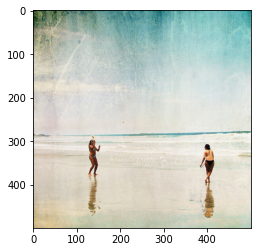

Generated_Sentence:
two women are playing racquet game on the beach picture snowfall boulders skirt skirt counter stroller windows skirt skirt beach skirt picture beach picture skirt picture beach skirt 
Actual Caption: 
two people play on the beach




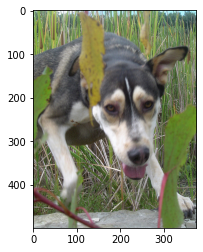

Generated_Sentence:
black brown and tan dog jumps at the camera store passage pond seafood passage off stroller windows skirt skirt dandelions tree one tree female ear one sos one 
Actual Caption: 
black and brown dog staring off into the distance at something




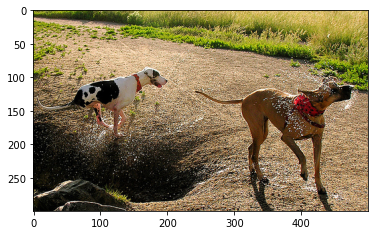

Generated_Sentence:
brown dog and black and white dog stand beside hole 
Actual Caption: 
black and white dog jumping out of the water and brown dog shaking off




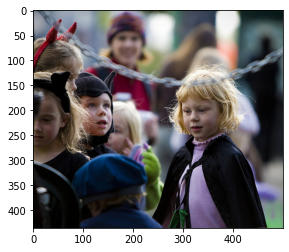

Generated_Sentence:
girl 
Actual Caption: 
blonde girl in black cape stands with other children in costumes




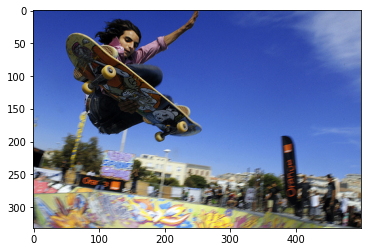

Generated_Sentence:
closeup of man skateboarding 
Actual Caption: 
child doing jump on skateboard




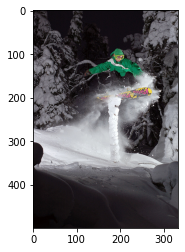

Generated_Sentence:
person 
Actual Caption: 
man wearing green jacket and hat is snowboarding




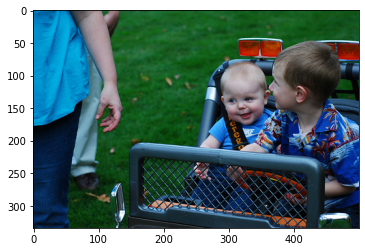

Generated_Sentence:
two children riding 
Actual Caption: 
boy and baby in ridable truck




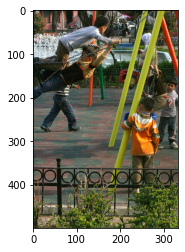

Generated_Sentence:
children playing on swing set at park picture seafood picture picture clothing skirt skirt off clothing female skirt skirt passage skirt one clothing lake clothing picture skirt field 
Actual Caption: 
children are playing on the swings at park




In [ ]:
tmp = Generate_Caption(transformer_model, dev_names[30:40], descriptions)

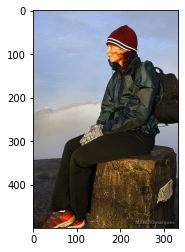

Generated_Sentence:
hiker 
Actual Caption: 
girl wearing brown cap red sneakers and dark green coat sits on rock bench




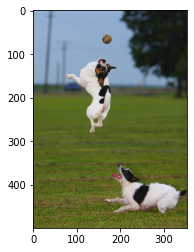

Generated_Sentence:
the two dogs one of which is leaping 
Actual Caption: 
one dog leaps to catch softball while another looks on




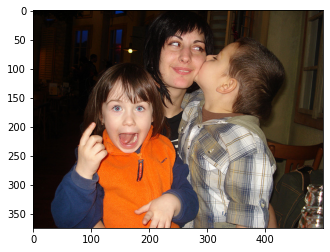

Generated_Sentence:
lightcolored and two children are posing with trainer faces store skirt passage skirt occupied foliage flops windows paved skirt passage skirt one paved beside skirt picture skirt paved 
Actual Caption: 
boy is kissing woman on the cheek next to girl who is wide eyed and sticking out her tongue




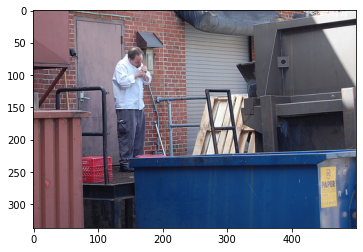

Generated_Sentence:
man is lighting smoke outside of building passage seafood occupied passage passage seafood occupied occupied stroller train paved one passage get one get female clothing arch sos one 
Actual Caption: 
man in white restaraunt shirt smokes next to dumpster




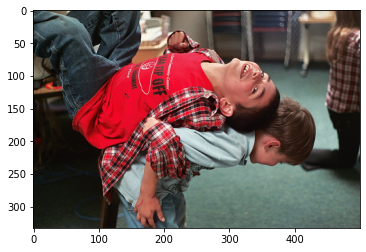

Generated_Sentence:
one boy another boy up on his back seafood store passage passage seafood passage foliage stroller blondehaired skirt one passage get one paved female clothing one skirt one 
Actual Caption: 
boy pulls other boy over back




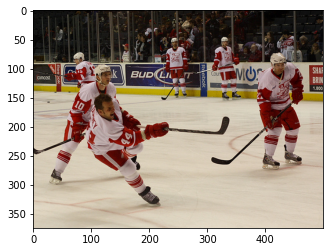

Generated_Sentence:
team of hockey players with one player taking shot store seafood pond seafood picture foliage flops windows skirt skirt dandelions get one paved picture clothing picture skirt one 
Actual Caption: 
group of men playing hockey




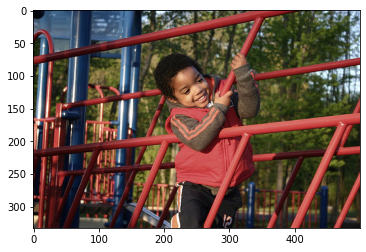

Generated_Sentence:
little boy playing on playground seafood occupied passage seafood occupied seafood pond skirt occupied occupied clothing female occupied one passage clothing one clothing female clothing one skirt one 
Actual Caption: 
little boy in red jacket plays on jungle gym




In [ ]:
tmp2 = Generate_Caption(transformer_model, test_examples, descriptions)

In [ ]:
test_image_arr = []
test_sentence_arr = []
for name in tqdm(test_names):
  image_location = name
  sentence = descriptions[name[:-4]]

  test_image_arr.append(load_image(os.path.join(root_direction,'Flicker/Flickr8k_Dataset/Flicker8k_Dataset', image_location)))
  test_sentence_arr.append(sentence)
    
        
Test_Images =  np.array(test_image_arr)

In [ ]:
test_sentence_arr[0]

In [ ]:
Test_Images.shape

In [ ]:
def evaluate(images_name, captions):
  actual_list, actual_captions, predicted_list,  = list(), list(), list()
  actual_captions.extend([[cap.split() for cap in cap_list] for cap_list in captions])
  predicted_list = Generate_Caption(images_name, captions, False)

  print('BLEU-1: %f' % corpus_bleu(actual_captions, predicted_list, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual_captions, predicted_list, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual_captions, predicted_list, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual_captions, predicted_list, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
evaluate(test_names, test_sentence_arr)